# What is an experiment measuring?
Marco Raveri (mraveri@sas.upenn.edu) 

In this notebook we show a worked example of how to go from the posterior of a given experiment to understanding the physics that controls its best constrained properties.

We work with the results of the Dark Energy Survey (DES) first year of data (https://arxiv.org/abs/1708.01530).
Specifically we consider the full weak lensing and galaxy clustering (3x2) analysis.

In [1]:
# Show plots inline, and load main getdist plot module and samples class
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1
# import libraries:
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'../..')))
from getdist import plots, MCSamples
from getdist.gaussian_mixtures import GaussianND
import getdist
getdist.chains.print_load_details = False
import scipy
import matplotlib.pyplot as plt
import IPython
from IPython.display import Markdown
import numpy as np
import seaborn as sns
# import the tensiometer tools that we need:
from tensiometer import utilities
from tensiometer import gaussian_tension

We now import the chains with the parameter posteriors.

Notice that we have removed many parameters from the chains since they were irrelevant to the example.
The chains are already fully polished. Burn in has been removed and the samples have been thinned (to save space on github).

We have run a prior only chain to ensure that the modeling of the prior is as faithful as possible.
In particular, in standard cosmological analyses, we have priors on derived parameters that would give non-trivial shapes to the parameters that are being sampled (see for example Appendix F in https://arxiv.org/abs/1806.04649)

In [2]:
# load the chains (remove no burn in since the example chains have already been cleaned):
chains_dir = './../../test_chains/'
# the DES Y1 3x2 chain:
chain = getdist.mcsamples.loadMCSamples(file_root=chains_dir+'DES', no_cache=True)
# the prior chain:
prior_chain = getdist.mcsamples.loadMCSamples(file_root=chains_dir+'prior', no_cache=True)
# we add a couple of derived parameters that have been removed from the chains (to save a little space):
for ch in [chain, prior_chain]:
    p = ch.getParams()
    ch.addDerived(p.omegach2/(p.H0/100.)**2, name='omegac', label='\\Omega_c')
    ch.addDerived(p.omegabh2/(p.H0/100.)**2, name='omegab', label='\\Omega_b')
    ch.addDerived(p.sigma8*np.sqrt(p.omegam/0.3), name='S8', label='S_8')

Now we look at the parameters that were used to run the chain and we plot them against the prior:

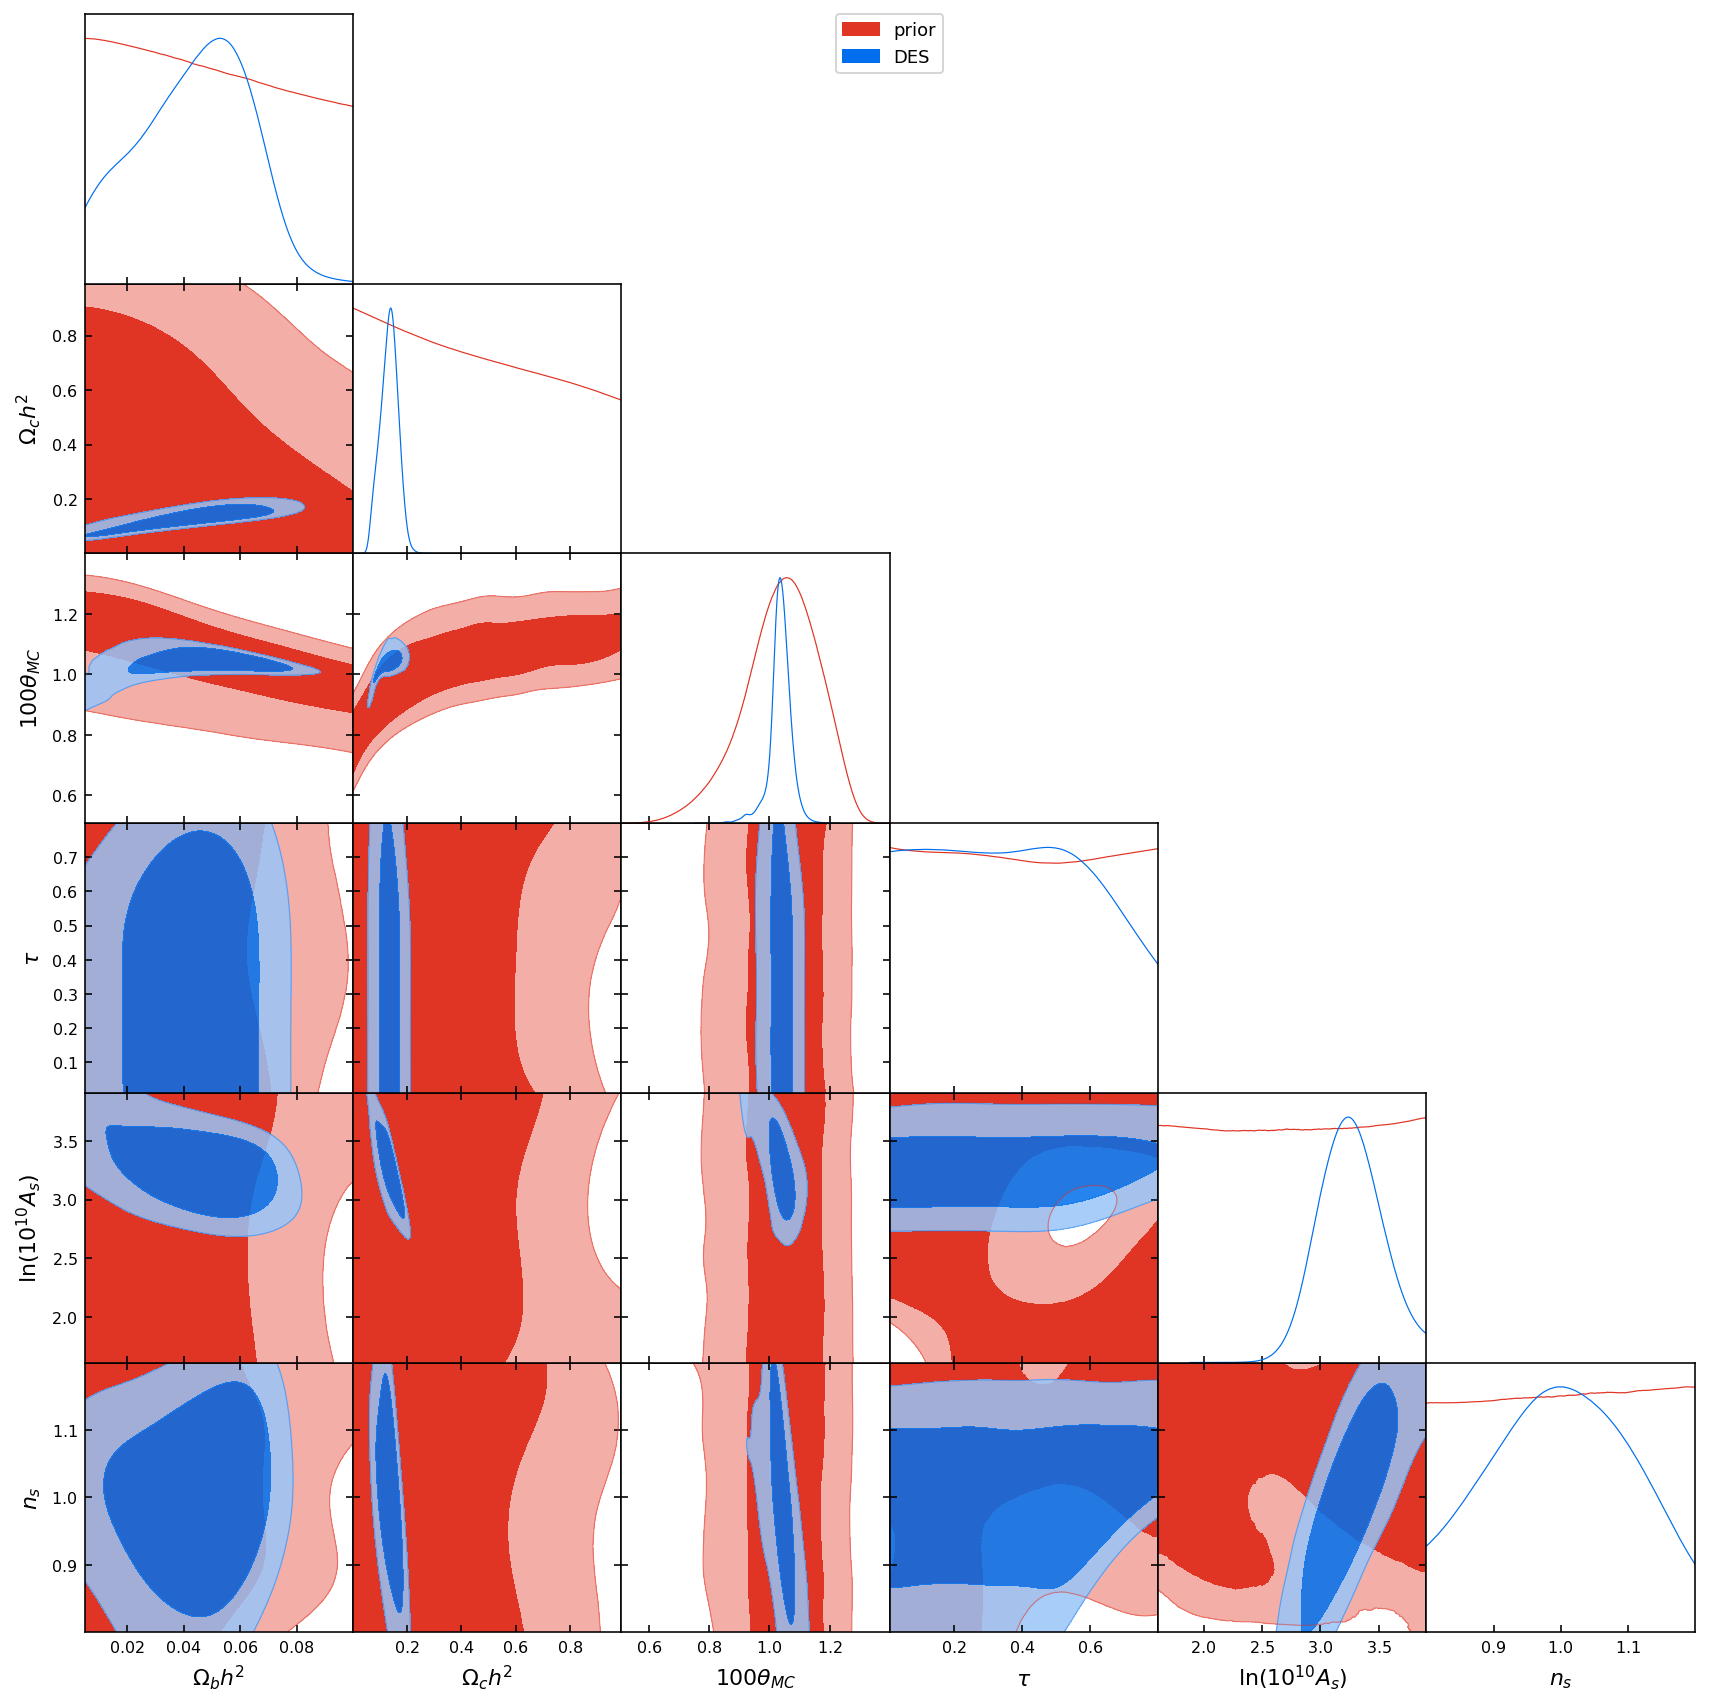

In [3]:
param_names = chain.getParamNames().getRunningNames()
g = plots.get_subplot_plotter()
g.triangle_plot([prior_chain, chain], params=param_names, filled=True)

This plot is not particularly illuminating. We might guess that 4 parameteres are constrained but it is hard to be sure about the number because of degeneracies.

To quantify how many parameters DES is measuring over the prior we compute the number of constrained parameters:

\begin{align}
N_{\rm eff} \equiv N -{\rm Tr}(C_\Pi^{-1} C_p)
\end{align}

as defined in (https://arxiv.org/pdf/1806.04649.pdf) and where $C_\Pi$ is the prior covariance, $C_p$ is the posterior covariance and $N$ is the nominal number of parameters.
This tells us how many parameters the data set is measuring. Notice that one important property is that this quantity is reparametrization invariant so it does not really depend on the specific parameters that we are using.

In [4]:
gaussian_tension.get_Neff(chain, param_names=param_names, prior_chain=prior_chain)

3.3147726236832553

This tells us that DES is measuging three cosmological parameters that we now try to nail down.

Since the number of constrained parameters is reparametrization invariant we first use some of our physical intuition. A reading of (https://arxiv.org/abs/astro-ph/9709112) should convince us that we can neglect $\tau$ and $H_0$.

In [5]:
param_names = ['omegam', 'omegab','sigma8','ns']

We can plot these parameters:

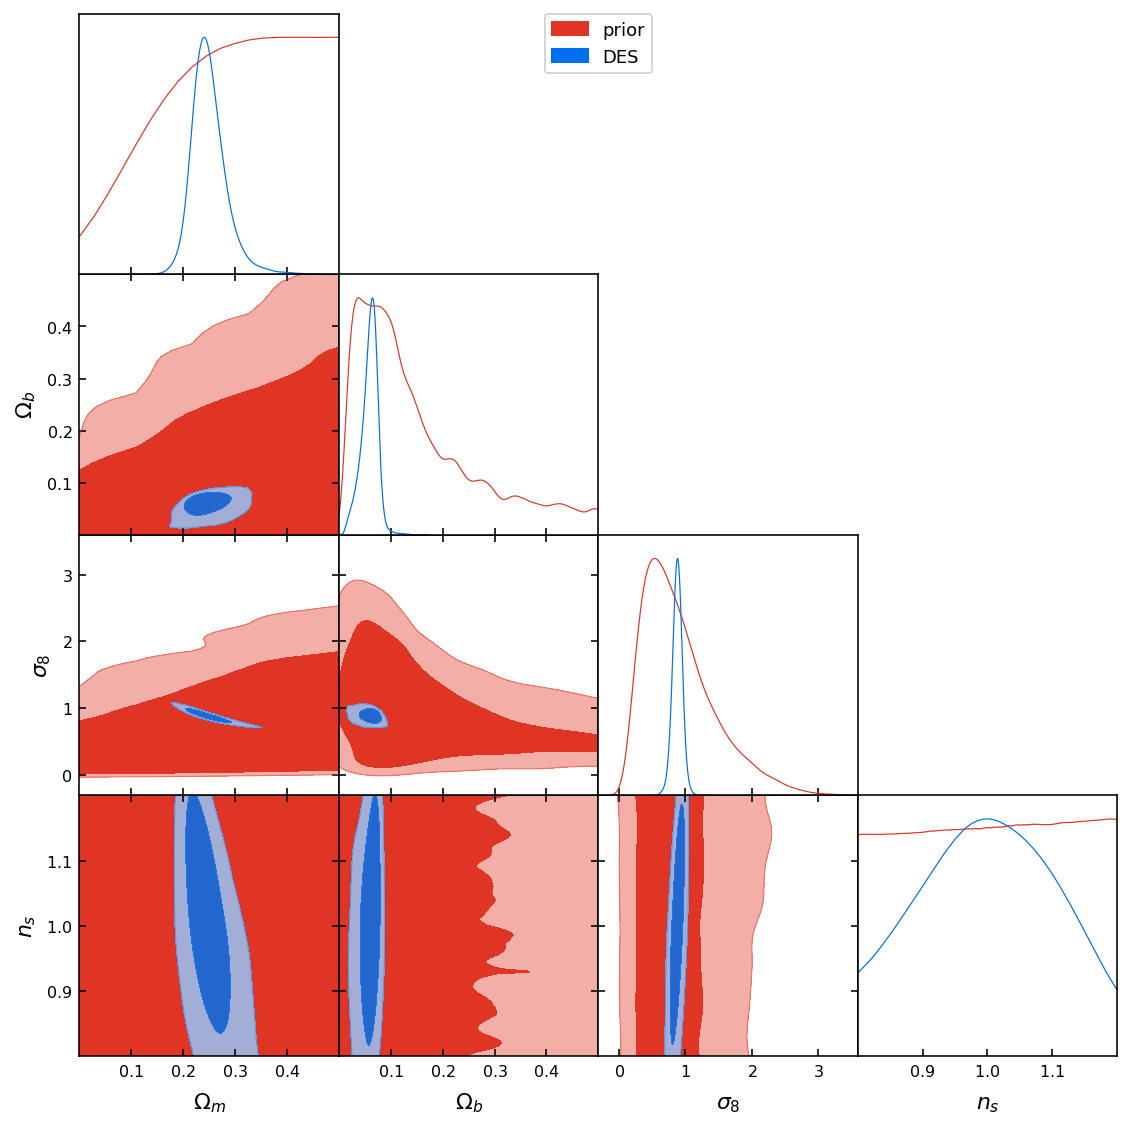

In [6]:
param_limits = {'omegam':[0.,.5], 'omegab':[0.,.5]}
g = plots.get_subplot_plotter()
g.triangle_plot([prior_chain,chain], params=param_names, filled=True, param_limits=param_limits)

This gives us a picture that is closer to our expectation of three+ constrained parameters and we can verify that by recomputing the number of constrained parameters in this parameter basis:

In [7]:
gaussian_tension.get_Neff(chain, param_names=param_names, prior_chain=prior_chain)

3.2528997083638838

As we can see we have all the parameters that we need. Possibly the constraint on $H_0$ makes up for the extra 0.1 parameter.

Still the parameters that we have here are degenerate and we want to disentangle them to better understand their physical meaning.

To do so we first add the log of these three parameters.

In [8]:
for ch in [chain, prior_chain]:
    p = ch.getParams()
    ch.addDerived(np.log(p.omegam), name='log_omegam', label='\\log \\Omega_m')
    ch.addDerived(np.log(p.omegab), name='log_omegab', label='\\log \\Omega_b')
    ch.addDerived(np.log(p.sigma8), name='log_sigma8', label='\\log \\sigma_8')
    ch.addDerived(np.log(p.ns), name='log_ns', label='\\log n_s')

Then we compute the KL decomposition of the posterior covariance with respect to the prior covariance.
As discussed in (https://arxiv.org/pdf/1806.04649.pdf) this quantifies the directions that the posterior is improving over the prior.
Although these directions are expressed in the given parameter basis they are reparametrization invariant.
Notice that this is not true for Principal Component Analysis (PCA) even if we were to apply it to the correlation matrix.

In [9]:
# do the KL decomposition on the log parameters:
KL_param_names = ['log_'+name for name in param_names]
# compute the KL modes:
KL_eig, KL_eigv, _ = gaussian_tension.Q_UDM_KL_components(prior_chain, chain, param_names=KL_param_names)
# sort them in order of improvement over the prior:
idx = np.argsort(KL_eig)[::-1]
KL_eig = KL_eig[idx]
KL_eigv = KL_eigv[:,idx]
#
with np.printoptions(precision=3, suppress=True):
    print('Improvement factor over the prior:', KL_eig)
    print('Improvement in error units:', np.sqrt(KL_eig-1))

Improvement factor over the prior: [1339.211   43.596    6.21     1.324]
Improvement in error units: [36.582  6.527  2.283  0.569]


As we can see we have three parameters whose error bar is improved over the prior by more than a factor of two. The last mode shows a modest 50% improvement.

We now want to plot the projection of these modes over parameters to see what parameter is contributing the most (in units of its variance).

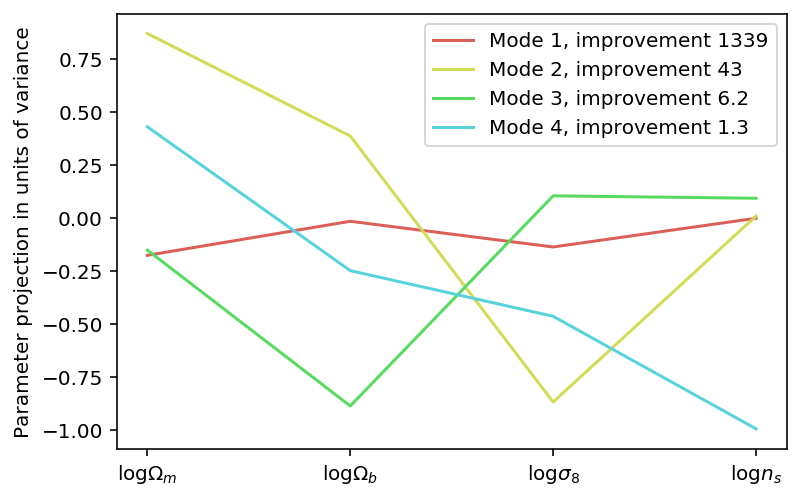

In [10]:
# compute the parameter space combinations corresponding to KL modes:
param_directions = np.linalg.inv(KL_eigv.T)
# we then compute the error bars on each of the parameters:
temp = np.sqrt(np.diag(chain.cov(KL_param_names)))
# plot them:
plt.plot(param_directions[:,0]/temp, label='Mode 1, improvement '+str(int(KL_eig[0])), color=sns.hls_palette(6)[0] )
plt.plot(param_directions[:,1]/temp, label='Mode 2, improvement '+str(int(KL_eig[1])), color=sns.hls_palette(6)[1])
plt.plot(param_directions[:,2]/temp, label='Mode 3, improvement '+str(round(KL_eig[2],1)), color=sns.hls_palette(6)[2])
plt.plot(param_directions[:,3]/temp, label='Mode 4, improvement '+str(round(KL_eig[3],1)), color=sns.hls_palette(6)[3])
ticks  = np.arange(len(param_names))
labels = [ '$'+chain.getParamNames().parWithName(name).label+'$' for name in KL_param_names ]
plt.xticks(ticks, labels);
plt.ylabel('Parameter projection in units of variance')
plt.legend();

As we can see the first mode corresponds to a correlated change in $\Omega_m$ and $\sigma_8$, as we would expect. The second mode on the other hand is the one where $\Omega_m$ and $\sigma_8$ variations are negatively correlated. The third mode is almost entirely projecting on $\Omega_b$.
The fourth mode is projecting the most over $n_s$ and is the worse constrained one as we might have guessed from the triangle plot.

We can easily visualize these modes in the triangle plot. For simplicity we do not plot the fourth mode.

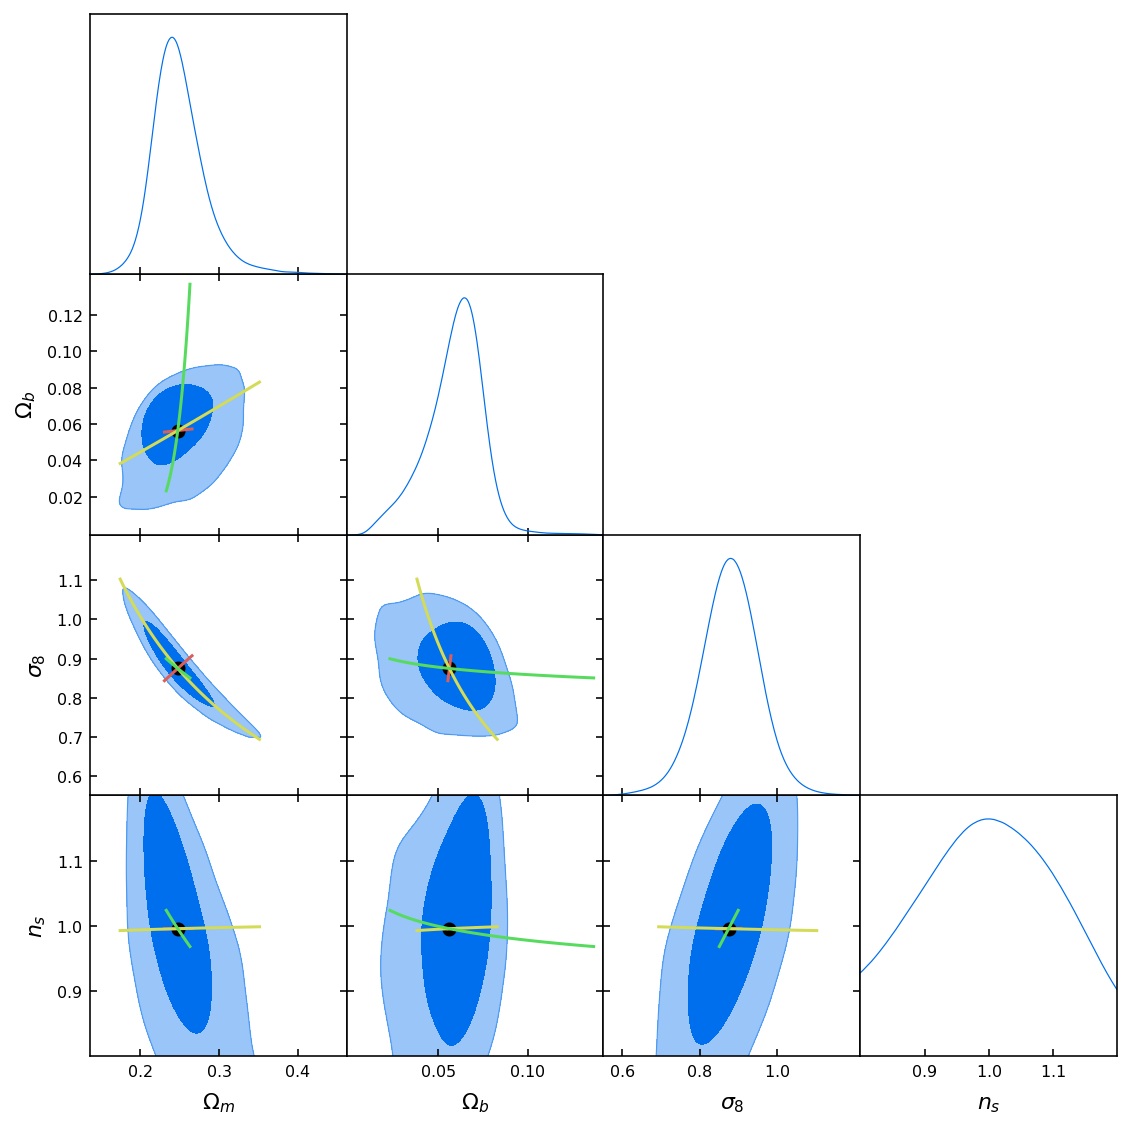

In [11]:
g = plots.get_subplot_plotter()
g.triangle_plot([chain], params=param_names, filled=True)
# add the modes:
for i in range(len(param_names)-1):
    for j in range(i+1,len(param_names)):
        ax = g.subplots[j,i]
        # get mean:
        m1, m2 = chain.getMeans(pars=[chain.index[name]
                       for name in [KL_param_names[i], KL_param_names[j]]])
        ax.scatter(np.exp(m1), np.exp(m2), color='k')
        alpha = 3.*np.linspace(-1.,1.,100)
        ax.plot(np.exp(m1+alpha*param_directions[:,0][i]), np.exp(m2+alpha*param_directions[:,0][j]), color=sns.hls_palette(6)[0])
        ax.plot(np.exp(m1+alpha*param_directions[:,1][i]), np.exp(m2+alpha*param_directions[:,1][j]), color=sns.hls_palette(6)[1])
        ax.plot(np.exp(m1+alpha*param_directions[:,2][i]), np.exp(m2+alpha*param_directions[:,2][j]), color=sns.hls_palette(6)[2])

Since we are considering the logarithm of parameters our KL decomposition corresponds to a power law decomposition.
One exponent can be fixed to one and the others are readly given by the KL mode:

In [12]:
print(param_names)
with np.printoptions(precision=3, suppress=True):
    print('Mean: ', np.exp(chain.getMeans(pars=[chain.index[name] for name in KL_param_names])))
    print('Mode 1, exponent:', KL_eigv.T[0,:]/KL_eigv.T[0,param_names.index('sigma8')])
    print('Mode 2, exponent:', KL_eigv.T[1,:]/KL_eigv.T[1,param_names.index('sigma8')])
    print('Mode 3, exponent:', KL_eigv.T[2,:]/KL_eigv.T[2,param_names.index('omegab')])

['omegam', 'omegab', 'sigma8', 'ns']
Mean:  [0.248 0.056 0.875 0.995]
Mode 1, exponent: [ 0.678 -0.015  1.    -0.008]
Mode 2, exponent: [-0.521  0.043  1.    -0.755]
Mode 3, exponent: [-0.597  1.     0.753 -1.496]


In this power law decomposition the sensitivity to parameters is not built in. As an example the exponential of $n_s$ is large but the effect on the parameters (see the above triangle plot) is very limited.

An aproximation for the best constrained parameter basis could be given:
\begin{align}
p_1 =& \sigma_8 \Omega_m^{0.7} \\
p_2 =& \sigma_8 \Omega_m^{-1/2} \\
p_3 =& \Omega_b \sigma_8^{0.7} \Omega_m^{-0.6}
\end{align}
Where we mostly have neglected the $n_s$ dependence that is very weak.

This parameter basis should single out the most constrained parameter space directions over the priors and as such should be less sensitive to volume effects in $\Lambda$CDM.

We next ask what is the physical meaning of these parameters. To do so we perform variations along the KL components and look at the matter power spectrum.

In [13]:
# first import camb
import camb
from camb import model
# then define helper to go from chains to camb parameters:
def camb_helper(chain, params):
    # parameters that we use:
    omegam, omegab, sigma8, ns = params
    # parameters that we fix:
    H0 = 70.
    tau = 0.079
    h = H0/100.
    # get the primordial amplitude from sigma8:
    mean_sigma8 = chain.getMeans(pars=[chain.index['sigma8']])
    mean_As = 1.e-10*np.exp(chain.getMeans(pars=[chain.index['logA']]))
    As = mean_As/np.sqrt(mean_sigma8)*np.sqrt(sigma8)
    # initialize:
    pars = camb.set_params(As = As,
                           ns = ns,
                           H0 = H0,
                           ombh2 = omegab*h**2,
                           omch2 = (omegam-omegab)*h**2,
                           mnu = 0.06,
                           tau = tau)
    # other settings:
    pars.set_matter_power(redshifts=[0.], kmax=10.0)
    #
    return pars

In [14]:
# compute mean cosmology:
mean_params = chain.getMeans(pars=[chain.index[name] for name in KL_param_names])
mean_camb_pars = camb_helper(chain, np.exp(mean_params))
mean_results = camb.get_results(mean_camb_pars)
kh, z, pk_ref = mean_results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 1000)

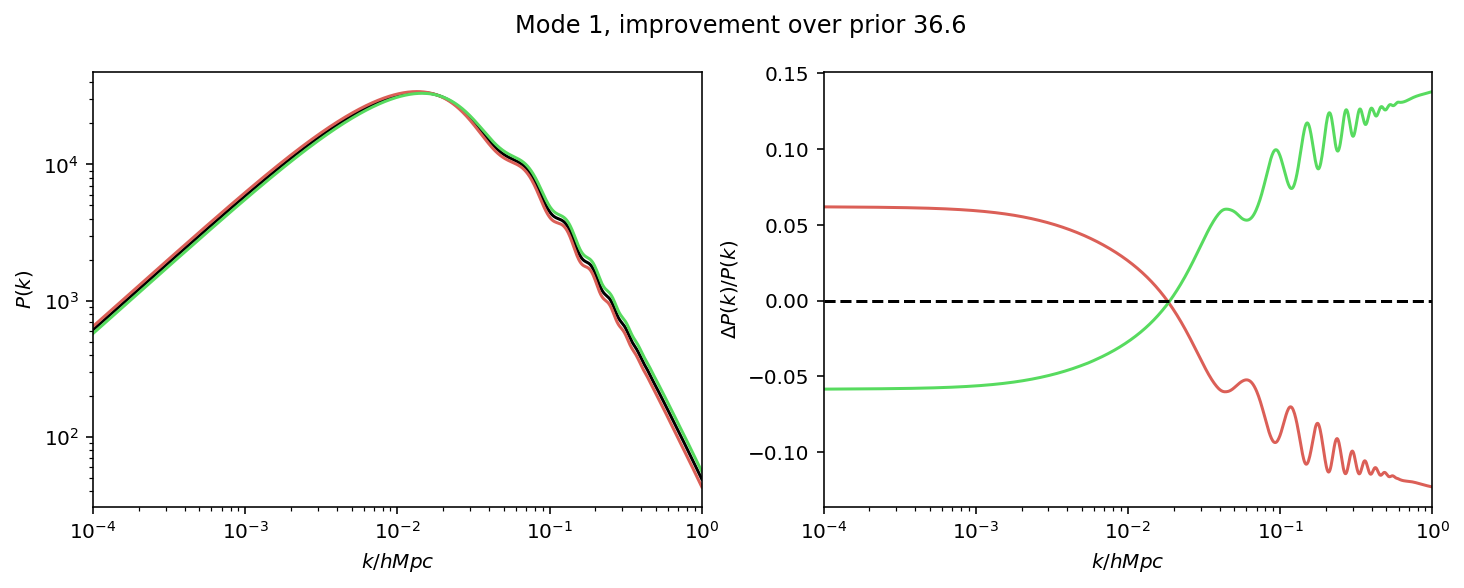

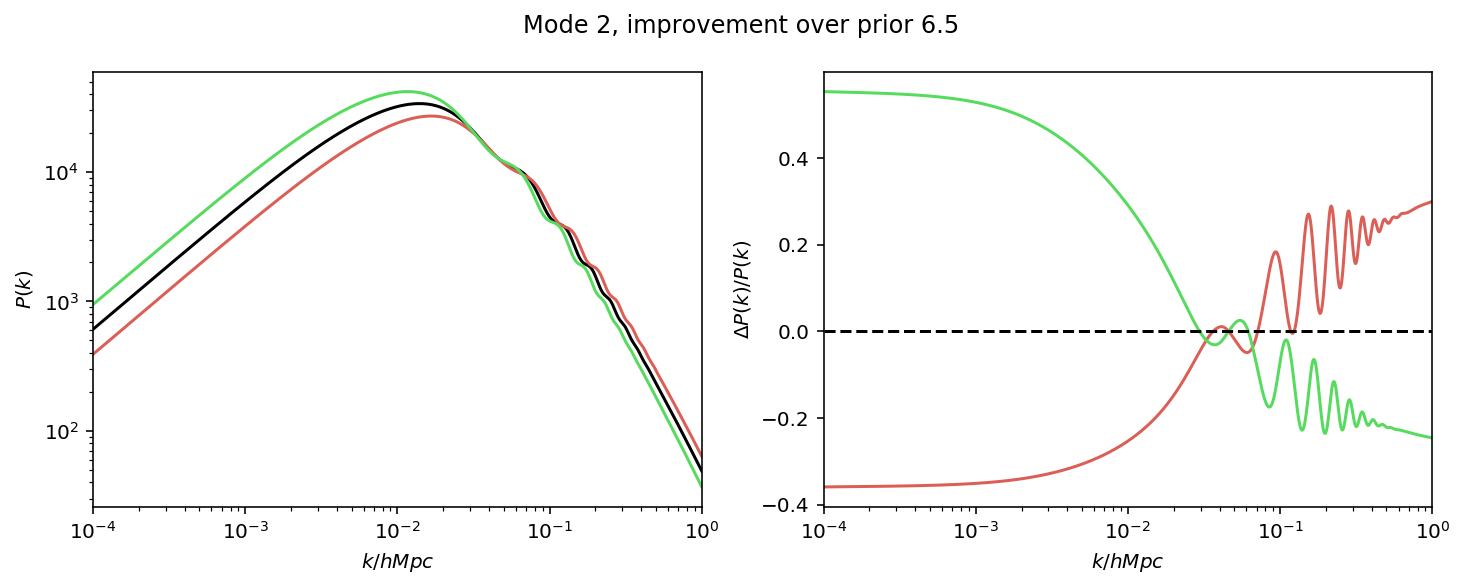

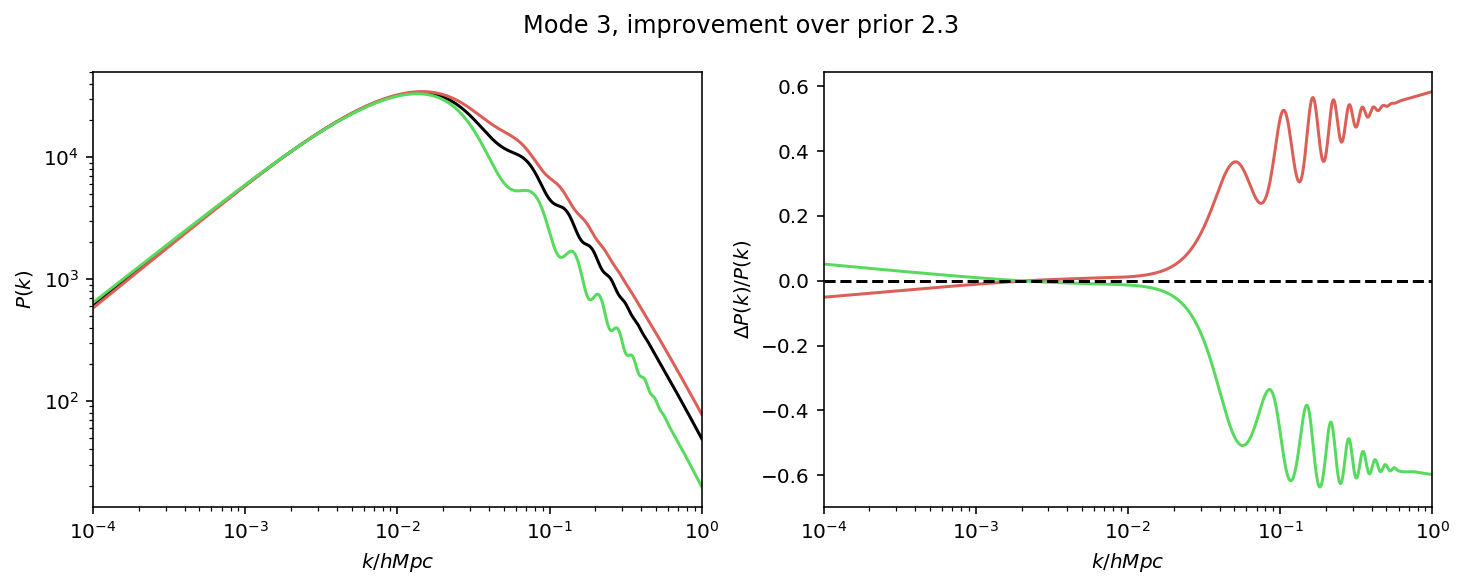

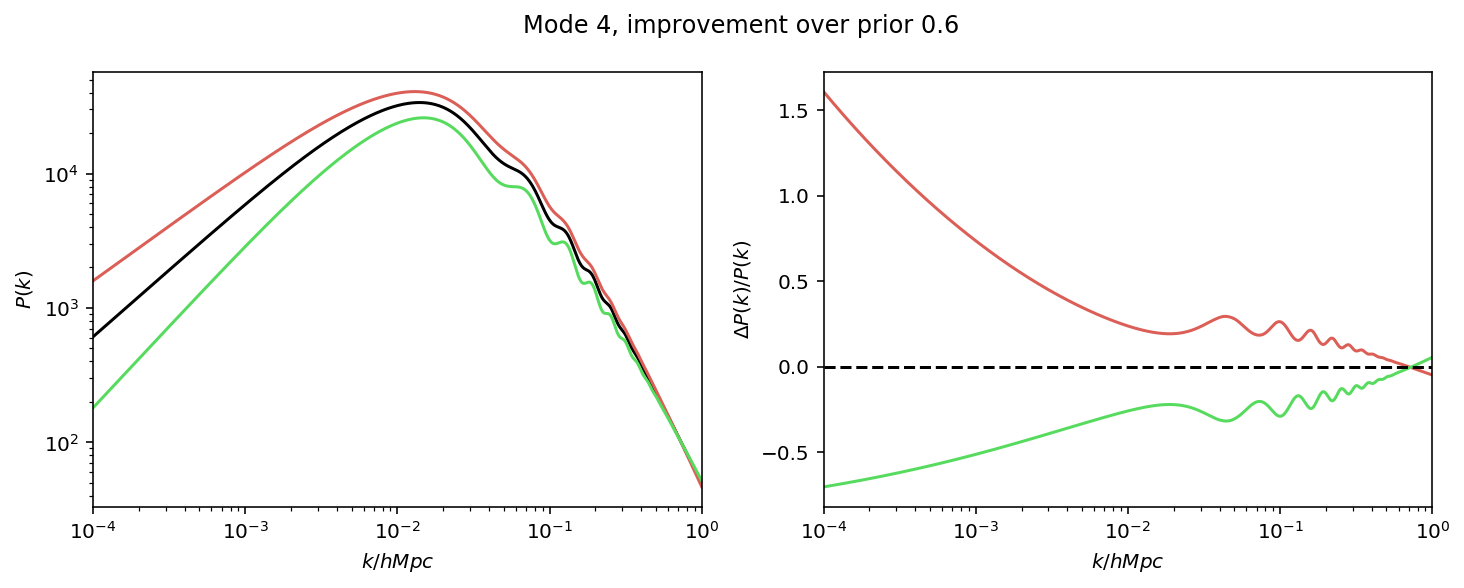

In [15]:
# now do parameter variations along the KL modes of the posterior with respect to the prior:
for ind in range(len(param_names)):
    # do a 2 sigma variation to see effects in the plots:
    camb_pars_plus = camb_helper(chain, np.exp(mean_params +2.*param_directions[:,ind]))
    camb_pars_minus = camb_helper(chain, np.exp(mean_params -2.*param_directions[:,ind]))
    # compute camb power spectra:
    results_plus = camb.get_results(camb_pars_plus)
    results_minus = camb.get_results(camb_pars_minus)
    _, _, pk_plus = results_plus.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 1000)
    _, _, pk_minus = results_minus.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 1000)
    # plot:
    fig, ax = plt.subplots(1,2, figsize = (12,4))
    fig.suptitle('Mode '+str(ind+1)+', improvement over prior '+str(round(np.sqrt(KL_eig[ind]-1),1)))
    ax[0].plot(kh, pk_ref[0], color='k')
    ax[0].plot(kh, pk_plus[0], color=sns.hls_palette(6)[0])
    ax[0].plot(kh, pk_minus[0], color=sns.hls_palette(6)[2])
    ax[0].set_yscale('log')
    ax[0].set_ylabel('$P(k)$')
    ax[1].plot(kh, (pk_plus[0]-pk_ref[0])/pk_ref[0], color=sns.hls_palette(6)[0])
    ax[1].plot(kh, (pk_minus[0]-pk_ref[0])/pk_ref[0], color=sns.hls_palette(6)[2])
    ax[1].axhline(0., ls='--', color='k')
    ax[1].set_ylabel('$\\Delta P(k)/ P(k)$')
    for _ax in ax:
        _ax.set_xlabel('$k/h Mpc$')
        _ax.set_xscale('log')
        _ax.set_xlim([np.amin(kh), np.amax(kh)])

As we can see the first two modes are quantifying differences in large to small scales power while the third mode is constraining small scales power at fixed large scale power.

We next look at the time evolution of a small scale mode in these two models. 
We only do one sided differences to maintain the plot easy to read.

In [37]:
a = np.logspace(-7.,0., 1000)
z = 1./a-1.
k = [1.0]
mean_ev = mean_results.get_redshift_evolution(k, z,['delta_cdm','delta_baryon','H'])

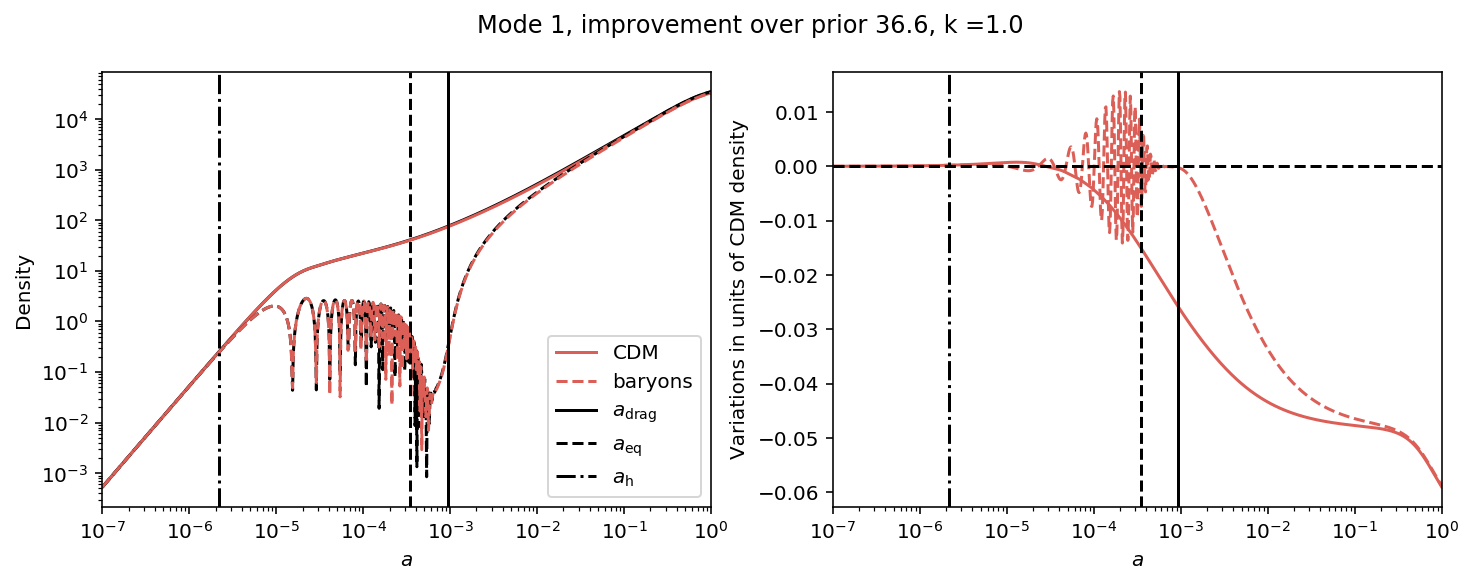

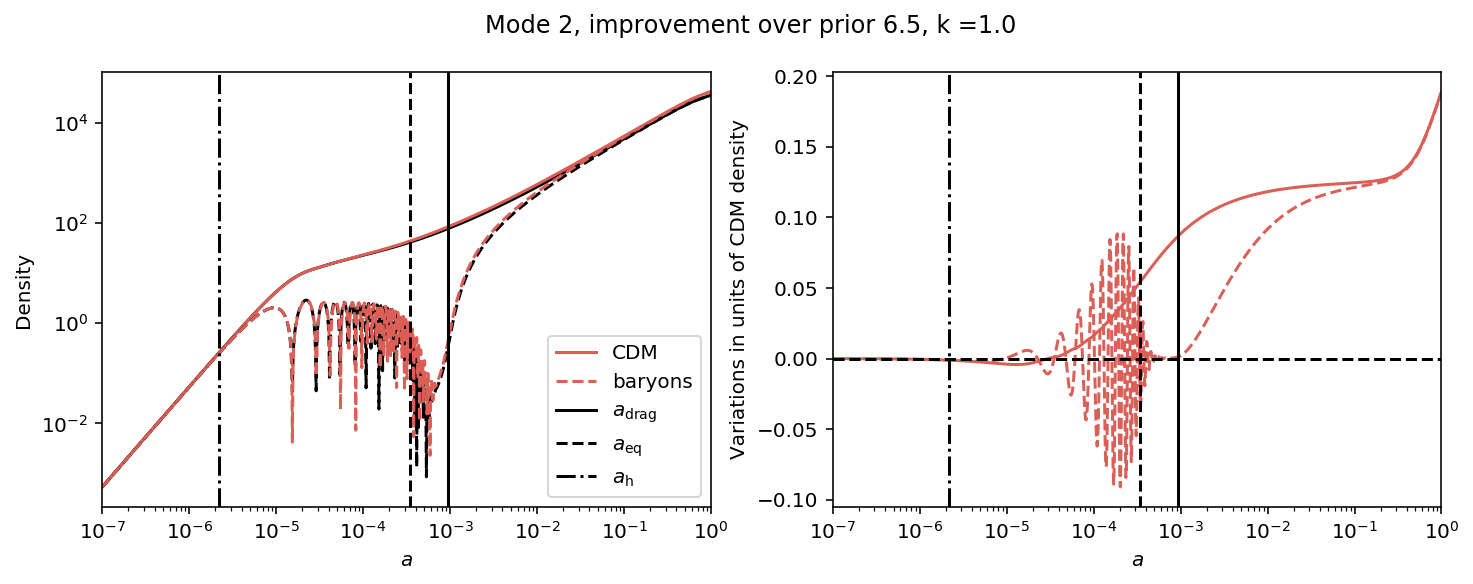

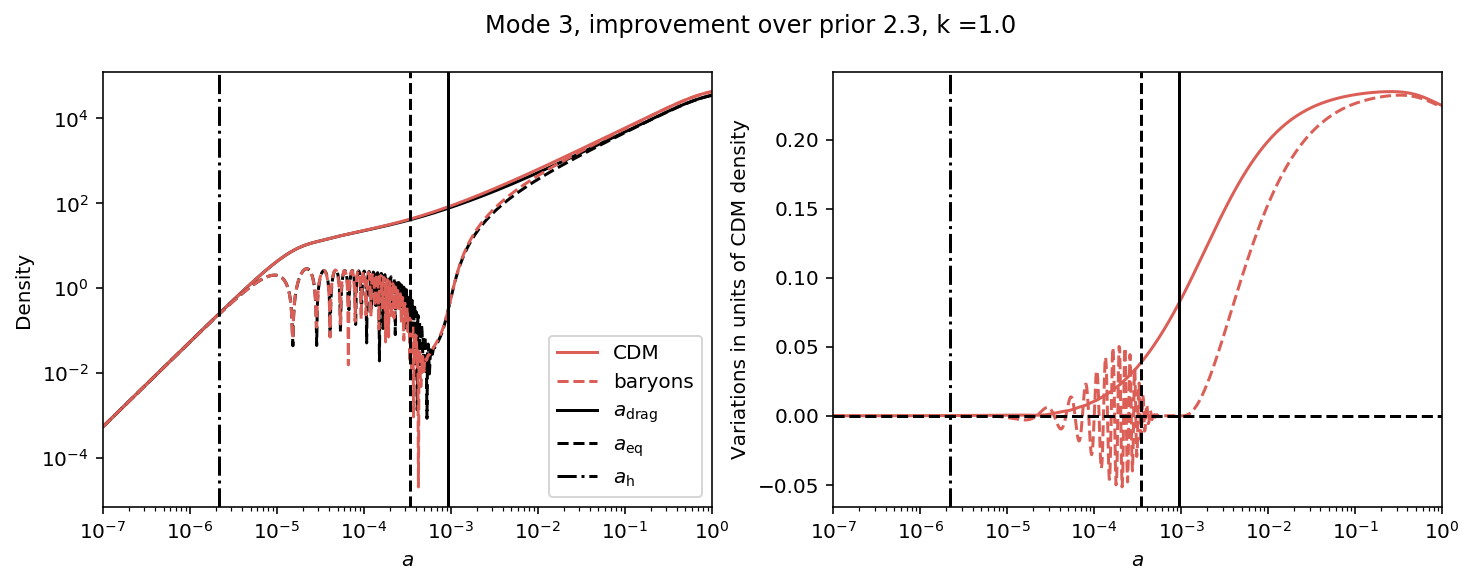

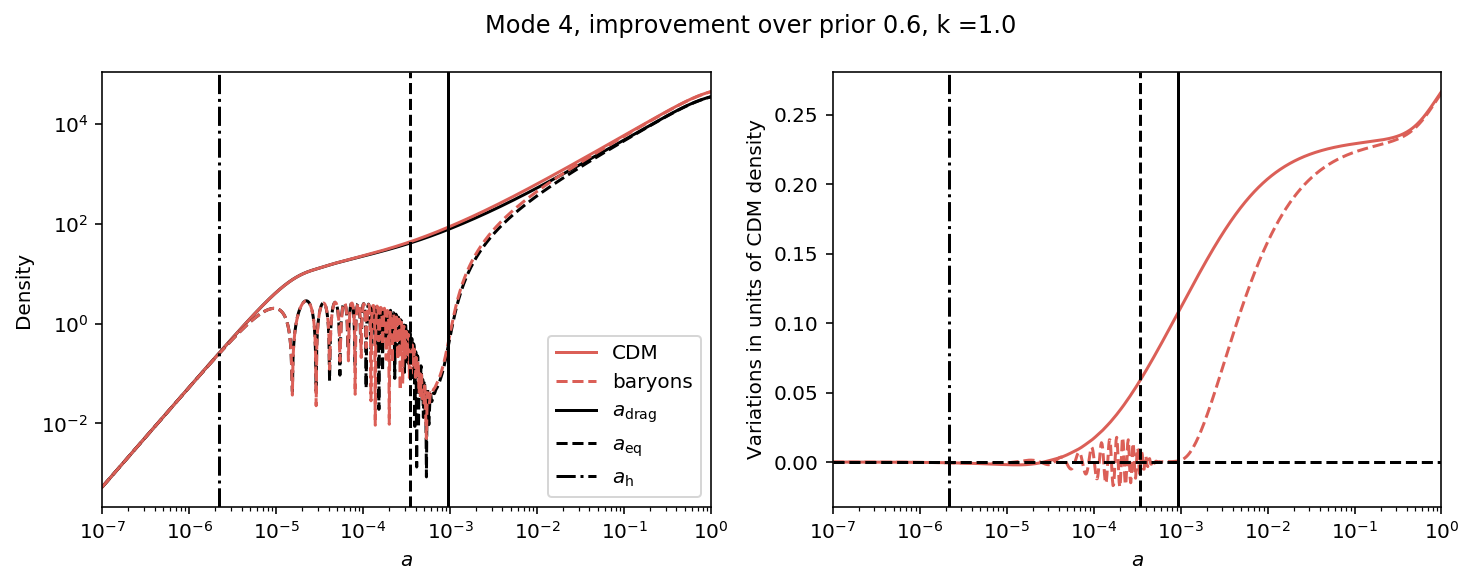

In [45]:
# now do parameter variations along the KL modes of the posterior with respect to the prior:
for ind in range(len(param_names)):
    # do a 2 sigma variation to see effects in the plots:
    camb_pars_plus = camb_helper(chain, np.exp(mean_params +2.*param_directions[:,ind]))
    camb_pars_minus = camb_helper(chain, np.exp(mean_params -2.*param_directions[:,ind]))
    # compute camb power spectra:
    results_plus = camb.get_results(camb_pars_plus)
    results_minus = camb.get_results(camb_pars_minus)
    # compute perturbation evolution:
    plus_ev = results_plus.get_redshift_evolution(k, z,['delta_cdm','delta_baryon','H'])
    minus_ev = results_minus.get_redshift_evolution(k, z,['delta_cdm','delta_baryon','H'])
    # plot:
    fig, ax = plt.subplots(1,2, figsize = (12,4))
    fig.suptitle('Mode '+str(ind+1)+', improvement over prior '+str(round(np.sqrt(KL_eig[ind]-1),1))+', k ='+str(k[0]))
    ax[0].plot(a, np.abs(mean_ev[0,:,0]), color='k')
    ax[0].plot(a, np.abs(plus_ev[0,:,0]), color=sns.hls_palette(6)[0], label='CDM')
    ax[0].plot(a, np.abs(mean_ev[0,:,1]), ls='--', color='k')
    ax[0].plot(a, np.abs(plus_ev[0,:,1]), ls='--', color=sns.hls_palette(6)[0], label='baryons')
    #ax[0].plot(a, np.abs(minus_ev[0,:,0]), color=sns.hls_palette(6)[2])
    ax[0].set_yscale('log')
    ax[0].set_ylabel('Density')
    ax[1].plot(a, (plus_ev[0,:,0]-mean_ev[0,:,0])/mean_ev[0,:,0], color=sns.hls_palette(6)[0])
    #ax[1].plot(a, (minus_ev[0,:,0]-mean_ev[0,:,0])/mean_ev[0,:,0], color=sns.hls_palette(6)[2])
    ax[1].plot(a, (plus_ev[0,:,1]-mean_ev[0,:,1])/mean_ev[0,:,0], ls='--', color=sns.hls_palette(6)[0])
    #ax[1].plot(a, (minus_ev[0,:,1]-mean_ev[0,:,1])/mean_ev[0,:,0], ls='--', color=sns.hls_palette(6)[2])
    ax[1].axhline(0., ls='--', color='k')
    ax[1].set_ylabel('Variations in units of CDM density')
    # vertical lines with relevant times:
    for _ax in ax:
        _ax.axvline(1./(1.+mean_results.get_derived_params()['zdrag']), ls='-', color='k', label='$a_{\\rm drag}$')
        _ax.axvline(1./(1.+mean_results.get_derived_params()['zeq']), ls='--', color='k', label='$a_{\\rm eq}$')
        _ax.axvline(a[np.argmin(np.abs(mean_ev[0,:,2]-k[0]))], ls='-.', color='k', label='$a_{\\rm h}$')       
        #_ax.axvline(1./(1.+results_plus.get_derived_params()['zdrag']), ls='-', color=sns.hls_palette(6)[0], label='$a_{\\rm drag}$')
        #_ax.axvline(1./(1.+results_plus.get_derived_params()['zeq']), ls='--', color=sns.hls_palette(6)[0], label='$a_{\\rm eq}$')
    for _ax in ax:
        _ax.set_xlabel('$a$')
        _ax.set_xscale('log')
        _ax.set_xlim([np.amin(a), np.amax(a)])
    #   
    ax[0].legend()       

As we can see the first two modes are dominated by the effect of changing $\Omega_m$ (that can also be easily seen by the corresponding decrease in $\Omega_\Lambda$ giving the growth enhancement at late times).
The third mode on the other hand is happening at mostly constant $\Omega_m$ (since there is no late time feature) and clearly shows the effect of CDM suppression/enhancement obtained by increasing/decreasing baryon density at fixed total matter density (see for example Sec. 5 of https://arxiv.org/pdf/astro-ph/9510117.pdf).
Notice that density perturbations are in units of primordial comoving curvature so we do not see the effect of changing the power spectrum parameters. 